# Deep Mixture of Experts for High-Level Intent Regression

We want to predict the likely bounds and trajectory of a given UAV during flight, based on its past trajectory and predicted intent class. In an ideal world, we would like to predict the exact path in 3D space over time (4 dimensions). The problem with doing this using a data-driven approach is that it would take a huge amount of data to work effectively, which is currently much beyond the data acquired during this research.

Instead, we can simplify the problem to become a regression task, which predicts the likely maximum position of the UAV forward in time for each dimension. This represents a multi-dimensional regression task, which can be achieved using supervised learning through the curation of a dataset using past flights of each intent class.

We'll use the same core data that was used for high-level intent classification (four classes: package delivery, perimeter, point-to-point and surveying flights). To create a suitable regression dataset we'll need to form sub-trajectories (like done previously), but also add suitable labels to each sub-trajectory corresponding to the maximum distance travelled from the last time instance in the window to 'n' timesteps in the future (e.g. 1 minute or 30 seconds). This does not need to be for just one set of predictions into the future, but could also include multiple predictions, e.g. one set for 10 seconds, another for 30, and another for 1 minute, which provides a useful set of predictions for where the UAV will be over different time periods in the future.

To achieve this, all future rows $n$ timesteps into the future from that sub-trajectory will need to be checked, and the maximum value for each cartesian coordinate used as the output label for each dimension. The type of flight will have a large impact on this, since for example, point-to-point flights will get progressively further and further with time, whereas perimeter or scanning flights might stay peak at a certain value and then decrease over time. 

The models used in this research are:

1. Multi Input Linear Regression (Baseline)

2. Multi Input LSTM.

3. Multi Input CBLSTM/CBLSTMA.

4. Multi Input CNN

5. Deep Mixture Of Experts (DMoE). Each expert based on Multi Input CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from time import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import keras.backend as K

from Framework.DataGeneration.DataPreprocessing import Preprocessing
from Framework.DataGeneration.Standardiser import TrajectoryStandardiser
from Framework.TrajectoryRegression.Visualization import Results
from Framework.DataGeneration.OutputStandardiser import OutputStandardiser, OutputNormaliser
from Framework.TrajectoryRegression.Linear_Regressor import Linear_Regression
from Framework.TrajectoryRegression.LSTM_Regressor import MultiInputLSTM
from Framework.TrajectoryRegression.CLSTM_Regressor import CLSTM_Regressor
from Framework.TrajectoryRegression.CNN_Regressor import CNN_Regressor
from Framework.TrajectoryRegression.MoE import MixtureOfExperts

In [2]:
# set random seeds - ensure consistent results
from numpy.random import seed
seed(14)
from tensorflow.random import set_seed
set_seed(14)

# set consistent style of plots
sns.set_style('white')

In [3]:
# To visualize beautiful plots
sns.set_style('white')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize = 16) 
plt.rc('ytick', labelsize = 16)
plt.rcParams['font.size'] = 16 
plt.rcParams['lines.linewidth'] = 2
plt.rc('savefig', dpi=300)
plt.rc('axes', titlesize = 16, labelsize = 16)
%matplotlib inline

In [4]:
# get project path and set data directory for notebook
PROJECT_PATH = os.getcwd()

DATA_DIR = os.path.join(PROJECT_PATH, 'ResearchData/simulated_measurements')
DEST_FOLDER = os.path.join(PROJECT_PATH,'FinalModels/Regression')
isExist = os.path.exists(DEST_FOLDER)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(DEST_FOLDER)
    print("The new directory is created!")

In [5]:
# High-level intent class
CLASSES = ['mapping_flight', 'package_delivery', 
           'perimeter_flight', 'point_point_flight']

# final dataframe to store all modelling results
final_results_df = pd.DataFrame()

## Formation of sub-trajectories and lookahead sequences

With our dataset of flights we want to process it into suitable sub-trajectories with associated bounding labels $n$ timesteps forward in time. For this, we will define a given window size for our sequences, along with a lookahead size for the considered future timesteps to be used for producing our labels for each sequence. The lookahead period will be measured ahead in time from the last timestep in the sequence. For each sequence we will determine the following from using the lookahead period:

$\bullet$ Maximum and minimum x-coordinate achieved $n$ timesteps in the future.

$\bullet$ Maximum and minimum y-coordinate achieved $n$ timesteps in the future.

$\bullet$ Maximum and minimum z-coordinate achieved $n$ timesteps in the future.

From these minimum and maximum figures at $n$, timesteps into the future, the differences between these and the last timestep values of the input sequence will be calculated. These differences will then be used as the values to predict using regression, which represent the possible bounds (in metres) that the UAV might be expected to traverse over the given lookahead interval.

We will also be able to define multiple lookahead points (n timesteps). In this research, we predict the bounds as defined above, for time periods of 15 seconds and 30 seconds into the future.

This means that for each input sub-trajectory, our models predict as accurately as possibly what the maximum and minimum bounds in 3-dimensional Cartesian space will be at at 15 seconds and 30 seconds.

In order to predict these outputs, our models will use the multivariate time-series UAV radar tracked features, along with associated meta data (high-level features and summary features) for each sub-trajectory.

In [6]:
# Initiate the Data preprocessor and plotter
Preprocessor = Preprocessing()
Plots = Results()

# define columns to keep as final input features
KEEP_COLS = ['est_x', 'est_y', 'est_z',
             'est_vel_x', 'est_vel_y', 'est_vel_z',
             'meas_range', 'meas_bearing', 'meas_elevation',
             'uav_type', 'uav_intent']

# define parameters for regression dataset generation
WINDOW_SIZE = 64 # random seed 14 for 8,16 & 32 window sizes

if WINDOW_SIZE >= 32:
    OVERLAP_FACTOR = 10 # use for window lengths 32 & 64
else:
    OVERLAP_FACTOR = 5 # use for window lengths of 8 & 16

# length of lookahead seq (must be at equal / greater to largest sample time)
LOOKAHEAD = 30

# sample times (in s) to generate bound labels from lookahead sequence
SAMPLE_TIMES = [15, 30]

# index for uav type above - for reference purposes during modelling
UAV_TYPE_IDX = 9

# index for intent class - needed for preprocessing / modelling
UAV_INTENT_IDX = 10

# define encoding mappers for our categorical features
UAV_TYPE_MAP = {'LSS' : 0, 
                'Fixed-Wing' : 1}

# define IDs to use for each intent class
UAV_INTENT_MAP = {'mapping_flight' : 0, 
                  'package_delivery' : 1,
                  'perimeter_flight' : 2, 
                  'point_point_flight' : 3}

In [7]:
# Generation of subtrajectories based on lookahead sequences
X = []
y = []
y_lookaheads = []
flight_refs = []

# iterate each class and generate sub-trajectories for flights
for class_name in tqdm(CLASSES):
    trajs, lookaheads, labels, refs = Preprocessor.get_class_reg_trajectories(class_name, 
                                                                               DATA_DIR, 
                                                                               KEEP_COLS, 
                                                                               WINDOW_SIZE,
                                                                               OVERLAP_FACTOR,
                                                                               LOOKAHEAD,
                                                                               SAMPLE_TIMES)
    
    X.append(trajs)
    y.append(labels)
    y_lookaheads.append(lookaheads)
    flight_refs.append(refs)

# convert overall results into numpy arrays
X = np.concatenate(X)
y = np.concatenate(y)
y_lookaheads = np.concatenate(y_lookaheads)
flight_refs = np.concatenate(flight_refs)
print(f"X shape: {X.shape} \ny shape: {y.shape}\n")
print(f"y lookaheads: {y_lookaheads.shape} \nFlight refs: {flight_refs.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:25<00:00, 21.27s/it]


X shape: (139454, 11, 64) 
y shape: (139454, 12)

y lookaheads: (139454, 11, 30) 
Flight refs: (139454,)


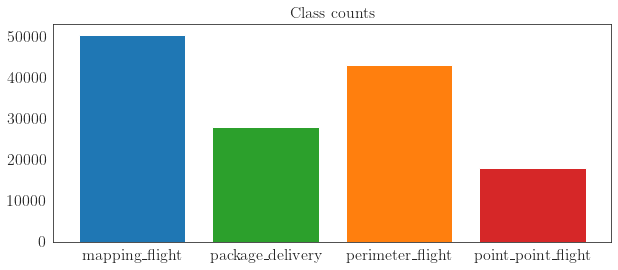

In [8]:
# Count the number of subtrajectory per class

intent_types = X[:, -1:, 0]

# assess number trajectories for each label and plot
cls_counts = np.unique(intent_types, return_counts=True)

plt.figure(figsize=(10,4))
plt.bar(x=cls_counts[0], height=cls_counts[1], color=['tab:blue', 'tab:green',
                                                      'tab:orange', 'tab:red'])
plt.title("Class counts", weight="bold")
plt.show()

In [9]:
# anomalous values (entries with beyond this will be removed)
# also remove minimum outliers (use absolute value instead)
ANOMALOUS_THRESHOLD = 10000
number = y[y.max(axis=1) > ANOMALOUS_THRESHOLD]
number.shape

(25, 12)

In [10]:
anomalous_idx = y.max(axis=1) > ANOMALOUS_THRESHOLD

# remove all anomalous values from our data
X = X[~anomalous_idx].copy()
y = y[~anomalous_idx].copy()
y_lookaheads = y_lookaheads[~anomalous_idx].copy()
flight_refs = flight_refs[~anomalous_idx].copy()

## Training, Validation and Test Splitting

We divide our data in suitable training, validation and test splitting sets. Suitable random state is required depending the window size. In this research, we propose some suitable values for the random seed, however some adjustements may be required until a sufficient balanced split of classes is obtained.

In [14]:
# choose appropriate random seed for splits of data
if (WINDOW_SIZE == 64) and (LOOKAHEAD == 30):
    R_STATE = 12 # use for window size 64
elif (WINDOW_SIZE == 64) and (LOOKAHEAD == 40):
    R_STATE = 18
elif (WINDOW_SIZE == 32) and (LOOKAHEAD == 40):
    R_STATE = 13
elif ((WINDOW_SIZE == 16) and (LOOKAHEAD == 40 or LOOKAHEAD == 30)):
    R_STATE = 13
elif (WINDOW_SIZE == 8) and (LOOKAHEAD == 30):
    R_STATE = 15  # 18 works good
else:
    R_STATE = 13
R_STATE

12

In [15]:
# Split the data into training, validation and testing datasets
(X_train, y_train, y_train_traj, 
 X_val, y_val, y_val_traj, 
 X_test, y_test, y_test_traj) = Preprocessor.DataSplitter(X, y, y_lookaheads, flight_refs,
                                                          val_size = 0.20, test_size = 0.10,
                                                          n_splits = 1, random_state = R_STATE)

(95704, 11, 64) (95704, 12) (95704, 11, 30)
(26684, 11, 64) (26684, 12) (26684, 11, 30)
(17041, 11, 64) (17041, 12) (17041, 11, 30)


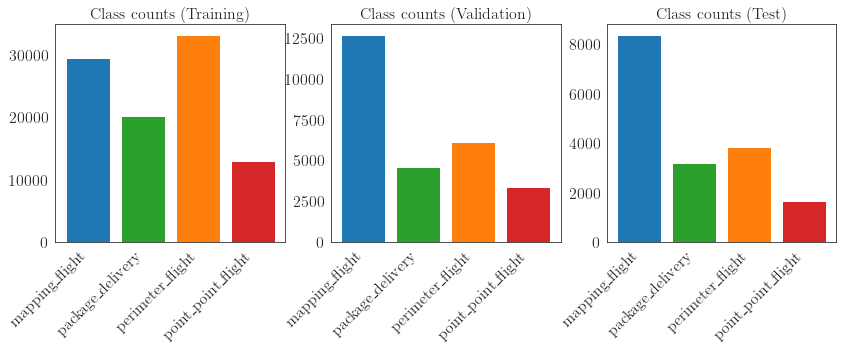

In [16]:
# assess number trajectories for each label and plot
trg_intents = X_train[:, -1:, 0]
cls_counts = np.unique(trg_intents, return_counts=True)

ticks = [x for x in range(len(cls_counts[0]))]

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].bar(x=cls_counts[0], height=cls_counts[1], color=['tab:blue', 'tab:green',
                                                        'tab:orange', 'tab:red'])
ax[0].set_title("Class counts (Training)", weight="bold")
ax[0].set_xticks(ticks=ticks, labels=cls_counts[0], 
                 rotation=45, ha='right')

# assess number trajectories for each label and plot
val_intents = X_val[:, -1:, 0]
cls_counts = np.unique(val_intents, return_counts=True)
ax[1].bar(x=cls_counts[0], height=cls_counts[1], color=['tab:blue', 'tab:green',
                                                        'tab:orange', 'tab:red'])
ax[1].set_title("Class counts (Validation)", weight="bold")
ax[1].set_xticks(ticks=ticks, labels=cls_counts[0], 
                 rotation=45, ha='right')

# assess number trajectories for each label and plot
test_intents = X_test[:, -1:, 0]
cls_counts = np.unique(test_intents, return_counts=True)
ax[2].bar(x=cls_counts[0], height=cls_counts[1], color=['tab:blue', 'tab:green',
                                                        'tab:orange', 'tab:red'])
ax[2].set_title("Class counts (Test)", weight="bold")
ax[2].set_xticks(ticks=ticks, labels=cls_counts[0], 
                 rotation=45, ha='right')
plt.show()

## Data Preprocessing and Standardisation


Just like performed with trajectory classification, we need to standardise our features so that they are scaled appropriately for our modelling. We'll use the means and standard deviations for each feature across all timesteps to standardise each feature to have approximately zero mean and 1 standard deviation. This will only be approximate however, given the time-series nature of the trajectories, which makes standardising effectively more complicated.

We also have two categorical columns (uav_type and intent_class), which we need to encode. Since these are constant across the entire trajectory, it makes sense to split these categorical features as seperate features for training. In addition to these high-level categorical features for each sub-trajectory, we will also compute summary point-based features for each sub-trajectory, including means, standard deviations, mins and maxes for each tracked feature. All of these features will be combined into summary (or meta) features.

In summary, we have two sets of modelling inputs:

1. Sub-Trajectory Multi-Variate Time-series Inputs - These are the UAV radar tracked features over time.

2. Summary features - These are the categorical features (UAV type and High-level intent), along with the summarising features for the sub-trajectory (means, std devs, mins, max).

For now, the labels will not be standardised, since the predicted responses are conveniently in terms of metres, and in general standardising output labels does not yield significant differences (inputs on the otherhand must be standardized!).


In [20]:
# instantiate our scaler and fit_tranform training, transform test
standardiser = TrajectoryStandardiser(num_upper_idx=UAV_TYPE_IDX, 
                        cat_idx=[UAV_TYPE_IDX, UAV_INTENT_IDX],
                        cat_mappers=[UAV_TYPE_MAP, UAV_INTENT_MAP])

# get standardised sequences and categorical feats
X_train_seq_std, X_train_meta = standardiser.fit_transform(X_train)
X_val_seq_std, X_val_meta = standardiser.transform(X_val)
X_test_seq_std, X_test_meta = standardiser.transform(X_test)

In [21]:
print(f"Training: \n - Seqs: {X_train_seq_std.shape}\n - Meta: {X_train_meta.shape}")
print(f"\nValidation: \n - Seqs: {X_val_seq_std.shape}\n - Meta: {X_val_meta.shape}")
print(f"\nTest: \n - Seqs: {X_test_seq_std.shape}\n - Meta: {X_test_meta.shape}")

Training: 
 - Seqs: (95704, 9, 64)
 - Meta: (95704, 262)

Validation: 
 - Seqs: (26684, 9, 64)
 - Meta: (26684, 262)

Test: 
 - Seqs: (17041, 9, 64)
 - Meta: (17041, 262)


In [22]:
# Check if the data has approximately mean zero
X_train_seq_std[:, :, :].astype('float').mean(axis=(2,0))

array([-1.16071358e-11, -1.02777785e-11, -2.54877850e-12, -2.31406170e-11,
        3.09160666e-11, -3.27458469e-11,  1.15803677e-12,  5.76730320e-11,
       -4.71686576e-12])

In [23]:
# Check if the data has approximately standard deviation 1
X_train_seq_std[:, :, :].astype('float').std(axis=(2,0))

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
# convert final labels into float32 for training
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [25]:
## Only use for standardisation and preprocessing of target values
#y_scaler = OutputStandardiser()

#y_train_std = y_scaler.fit_transform(y_train)
#y_val_std = y_scaler.transform(y_val)
#y_test_std = y_scaler.transform(y_test)

#y_train_std = y_train_std.astype('float32')
#y_val_std = y_val_std.astype('float32')
#y_test_std = y_test_std.astype('float32')


#y_normer = OutputNormaliser()
#y_train_norm = y_normer.fit_transform(y_train)
#y_val_norm = y_normer.transform(y_val)

#y_original = y_normer.inverse_transform(y_train_norm)

# Multiple Linear Regression (Baseline)


Similarly to the classification modelling, we'll create some simple baseline classical ML models to benchmark performance and compare against later.

Since these models do not support trajectory (sequential) inputs by default, we need to form some appropriate features to use as input for each associated trajectory. We'll do this using means, standard deviations, minimums and maximums.


In [ ]:
# Summary features data to train the Baseline model
X_train_sum = standardiser.get_seq_summary_feats(X_train_seq_std)
X_val_sum  = standardiser.get_seq_summary_feats(X_val_seq_std)
X_test_sum  = standardiser.get_seq_summary_feats(X_test_seq_std)

X_train_sum.shape, X_val_sum.shape, X_test_sum.shape

In [ ]:
# Instantiate a Linear Regression Model
LR = Linear_Regression()

# Traing the linear regression model
model_results, val_preds, test_preds = LR.LinearRegressor(X_train_sum, y_train,
                                                          X_val_sum, y_val,
                                                          X_test_sum, y_test,
                                                          WINDOW_SIZE)

# Save the results in a Data Frame for future export
final_results_df = final_results_df.append(model_results, ignore_index=True)

# Multiple Input LSTM

We'll feed both trajectory sequential features and trajectory summary (meta) features into the network. These meta features include the intent label for the flight (one hot encoded).

In [ ]:
# Instantiate the Multi Input LSTM network
lstm_model = MultiInputLSTM(epochs = 75, n_outputs = y.shape[1])
lstm_model.MultiInputLSTM(X_train_seq_std, X_train_meta).summary()

# Train the Multi Input LSTM network
lstm_history = lstm_model.train(X_train_seq_std, X_train_meta, y_train,
                 X_val_seq_std, X_val_meta, y_val)

In [ ]:
# RMSE results of the LSTM network
Plots.RMSE_plots(lstm_history)

# Results under the validation and testing sets
model_results, val_preds, test_preds = lstm_model.prediction(X_val_seq_std, X_val_meta, y_val,
                                                             X_test_seq_std, X_test_meta, y_test,
                                                             WINDOW_SIZE)
#append results to our final dataframe of results
final_results_df = final_results_df.append(model_results, ignore_index=True)

# Multi Input CBLSTMA 

In [ ]:
# Define the hyperparameters of the CLSTM/CBLSTMA network
convlstm_params = {'conv_filters':32, 'kernel_size':8,
                   'lstm_layers':16, 'cat_dense_units':64, 
                   'dense_units':64, 'rnn_dropout':0.4, 
                   'dense_dropout':0.4, 'activation':'relu', 
                   'lr':1e-3, 'n_outputs':y.shape[1], 'epochs': 125,
                  'batch_size': 128}

# Instantiate the regression model
clstm_model = CLSTM_Regressor(**convlstm_params)
clstm_model.MultiInputConvLSTM(X_train_seq_std, X_train_meta).summary()

# Train the Multi Input CBLSTMA
clstm_history = clstm_model.train(X_train_seq_std, X_train_meta, y_train,
                 X_val_seq_std, X_val_meta, y_val)

In [ ]:
# RMSE results of the CBLSTMA network
Plots.RMSE_plots(clstm_history)

# Results under the validation and testing sets
model_results, val_preds, test_preds, = clstm_model.prediction(X_val_seq_std, X_val_meta, y_val,
                                                               X_test_seq_std, X_test_meta, y_test,
                                                               WINDOW_SIZE)
# append results to our final dataframe of results
final_results_df = final_results_df.append(model_results, ignore_index=True)

# Multi Input Convolutional Neural Network (CNN)

In [ ]:
# Define the hyperparameters of the Multi Input CNN 
conv_dnn_params = {'conv_filters':32, 
                   'kernel_size':12, 
                   'cat_dense_units':64, 
                   'dense_units':64, 
                   'dense_dropout':0.4, 
                   'activation':'relu',
                   'loss':'mean_squared_error',
                   'lr':5e-4, 
                   'n_outputs':y.shape[1],
                   'epochs': 75,
                   'batch_size': 128}

# Instantiate the Multi-Input CNN class
cnn_model = CNN_Regressor(**conv_dnn_params)
cnn_model.MultiInputConv(X_train_seq_std, X_train_meta).summary()

# Train the Multi-Input CNN 
cnn_history = cnn_model.train(X_train_seq_std, X_train_meta, y_train,
                 X_val_seq_std, X_val_meta, y_val)

In [ ]:
# RMSE results of the Multi Input CNN
Plots.RMSE_plots(cnn_history)

# Results under the validation and testing sets
model_results, val_preds, test_preds = cnn_model.prediction(X_val_seq_std, X_val_meta, y_val,
                                                            X_test_seq_std, X_test_meta, y_test,
                                                            WINDOW_SIZE)

# append results to our final dataframe of results
final_results_df = final_results_df.append(model_results, ignore_index=True)

# Deep Mixture of Experts

A mixture of experts is a system or framework that consists of a range of expert models that are specialised to work with different kinds or subsets of inputs. The best expert candidates are then chosen by a gating function (or model) for a specific set of inputs. The result is a weighted ensemble of expert models, based on the type of inputs given at that time.

This kind of network is perfect for the framework being developed, since the gating function can be the high-level intent classification model previously developed. The predictions from this model can then be used as the gating inputs into the mixture of experts model. There will be a unique expert model trained for each high-level intent class. This will allow each model to focus specifically on the features of each class, which should hopefully help maximise performance.

The softmax outputs from the high-level intent classification model for a given sample can represent the weights (or proportions) used to determine the final predictions from the expert models.


In [26]:
# Names of the high-level intent classes
expert_names =list(UAV_INTENT_MAP.keys())

In [27]:
def MultiInputConvDNN(input_seqs, input_cats, 
                      conv_filters=20, kernel_size=8,
                      cat_dense_units=64, dense_units=64, 
                      dense_dropout=0.4, activation='relu',
                      loss='mean_squared_error',
                      lr=1e-3, n_outputs=6):
    """ Convolutional model for trajectory classification.
        Uses multiple inputs - both sequences and categorical features.
        Uses a Conv layer and several LSTM layers, followed by final 
        Dense network to classify input sequences. """
    
    seq_input = keras.layers.Input(shape=(input_seqs.shape[1], 
                                           input_seqs.shape[2]))
    
    # Conv layers for sequential inputs
    cnn_z = keras.layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, 
                                padding='same', strides=2, 
                                activation=activation)(seq_input)
    
    # add dropout regularisation to prevent overfitting
    z = keras.layers.Dropout(dense_dropout, name='cnn_dropout')(cnn_z)
    
    # follow-up convolutional layer
    z = keras.layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, 
                            padding='same', strides=2, 
                            activation=activation)(z)
    
    # flatten and apply dense layer
    cnn_dense = keras.layers.Flatten()(z)
    
    # define categorical inputs
    cat_input = keras.layers.Input(shape=(input_cats.shape[1]))
    
    # simple dense layer to process categorical inputs
    cat_dense = keras.layers.Dense(cat_dense_units, 
                activation=activation)(cat_input)
    
    # combine embeddings from both rnn and categorical components
    concat = keras.layers.Concatenate()([cat_dense, cnn_dense])
    
    # add dropout for regularisation
    dense = keras.layers.Dropout(dense_dropout)(concat)
    
    # dense layer to process combined embeddings
    dense = keras.layers.Dense(dense_units, 
                    activation=activation)(concat)
    
    # define dense output (no activation) for regression
    outputs = keras.layers.Dense(n_outputs)(dense)
    
    # build overall model with inputs and outputs
    model = keras.models.Model(inputs=[seq_input, cat_input], outputs=[outputs])
    
    # compile model with desired settings
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [28]:
# Define the hyperparameters of each expert model
model_params = {'input_seqs': X_train_seq_std,
                'input_cats': X_train_meta,
                'conv_filters':32, 
                'kernel_size':12,
                'cat_dense_units':64, 
                'dense_units':64, 
                'activation':'relu',
                'loss' : 'huber',
                'lr':5e-4, 
                'n_outputs':y.shape[1]}

# lets get our intent labels for training our experts
y_trg_intents = np.array(np.argmax(X_train_meta[:, 2:6], axis=1)).flatten()
y_val_intents = np.array(np.argmax(X_val_meta[:, 2:6], axis=1)).flatten()
y_test_intents = np.array(np.argmax(X_test_meta[:, 2:6], axis=1)).flatten()

# Instantiate the Deep Mixture of Experts
moe_model = MixtureOfExperts(MultiInputConvDNN, model_params = model_params, 
                             epochs = 150, expert_names = expert_names)

# Compute the training time
start_time = time()
# Train the DMoE
moe_model.train(X_train_seq_std, X_train_meta, y_train, y_trg_intents,
                              X_val_seq_std, X_val_meta, y_val, y_val_intents)
moe_training_time = time() - start_time
print(f"Deep MoE Total Training Time: {moe_training_time}")

Starting training for mapping_flight...
Epoch 1/150
230/230 [==============================] - 5s 9ms/step - loss: 27.1295 - root_mean_squared_error: 58.6822 - val_loss: 13.4310 - val_root_mean_squared_error: 25.1880 - lr: 5.0000e-04
Epoch 2/150
230/230 [==============================] - 2s 7ms/step - loss: 18.2272 - root_mean_squared_error: 39.5402 - val_loss: 9.8146 - val_root_mean_squared_error: 18.8149 - lr: 5.0000e-04
Epoch 3/150
230/230 [==============================] - 2s 8ms/step - loss: 15.6127 - root_mean_squared_error: 33.8114 - val_loss: 9.0484 - val_root_mean_squared_error: 17.6098 - lr: 5.0000e-04
Epoch 4/150
230/230 [==============================] - 2s 8ms/step - loss: 14.5320 - root_mean_squared_error: 31.3651 - val_loss: 8.6296 - val_root_mean_squared_error: 16.8003 - lr: 5.0000e-04
Epoch 5/150
230/230 [==============================] - 2s 8ms/step - loss: 13.7427 - root_mean_squared_error: 29.5533 - val_loss: 8.1180 - val_root_mean_squared_error: 16.1589 - lr: 5.000

230/230 [==============================] - 2s 9ms/step - loss: 8.4156 - root_mean_squared_error: 18.6457 - val_loss: 5.8900 - val_root_mean_squared_error: 13.2309 - lr: 5.0000e-04
Epoch 44/150
230/230 [==============================] - 2s 9ms/step - loss: 8.4012 - root_mean_squared_error: 18.6858 - val_loss: 5.9087 - val_root_mean_squared_error: 13.2578 - lr: 5.0000e-04
Epoch 45/150
230/230 [==============================] - 2s 9ms/step - loss: 8.3461 - root_mean_squared_error: 18.5324 - val_loss: 5.8829 - val_root_mean_squared_error: 13.3146 - lr: 5.0000e-04
Epoch 46/150
230/230 [==============================] - 2s 9ms/step - loss: 8.3531 - root_mean_squared_error: 18.5313 - val_loss: 5.8538 - val_root_mean_squared_error: 13.3923 - lr: 5.0000e-04
Epoch 47/150
230/230 [==============================] - 2s 9ms/step - loss: 8.2468 - root_mean_squared_error: 18.3659 - val_loss: 5.8684 - val_root_mean_squared_error: 13.2134 - lr: 5.0000e-04
Epoch 48/150
230/230 [==========================

230/230 [==============================] - 2s 9ms/step - loss: 7.2606 - root_mean_squared_error: 16.1843 - val_loss: 5.4758 - val_root_mean_squared_error: 12.6296 - lr: 1.2500e-04
Epoch 86/150
230/230 [==============================] - 2s 9ms/step - loss: 7.2973 - root_mean_squared_error: 16.2690 - val_loss: 5.4524 - val_root_mean_squared_error: 12.6406 - lr: 1.2500e-04
Epoch 87/150
230/230 [==============================] - 2s 9ms/step - loss: 7.2540 - root_mean_squared_error: 16.1951 - val_loss: 5.4507 - val_root_mean_squared_error: 12.5926 - lr: 1.2500e-04
Epoch 88/150
230/230 [==============================] - 2s 9ms/step - loss: 7.3029 - root_mean_squared_error: 16.3502 - val_loss: 5.4569 - val_root_mean_squared_error: 12.5822 - lr: 1.2500e-04
Epoch 89/150
230/230 [==============================] - 2s 9ms/step - loss: 7.2849 - root_mean_squared_error: 16.2960 - val_loss: 5.4650 - val_root_mean_squared_error: 12.7094 - lr: 1.2500e-04
Epoch 90/150
230/230 [==========================

230/230 [==============================] - 2s 10ms/step - loss: 7.1170 - root_mean_squared_error: 15.9028 - val_loss: 5.3905 - val_root_mean_squared_error: 12.4850 - lr: 6.2500e-05
Epoch 128/150
230/230 [==============================] - 2s 10ms/step - loss: 7.1055 - root_mean_squared_error: 15.8688 - val_loss: 5.3864 - val_root_mean_squared_error: 12.4835 - lr: 3.1250e-05
Epoch 129/150
230/230 [==============================] - 2s 9ms/step - loss: 7.1013 - root_mean_squared_error: 15.8528 - val_loss: 5.3832 - val_root_mean_squared_error: 12.4688 - lr: 3.1250e-05
Epoch 130/150
230/230 [==============================] - 2s 9ms/step - loss: 7.1097 - root_mean_squared_error: 15.8929 - val_loss: 5.3843 - val_root_mean_squared_error: 12.5065 - lr: 3.1250e-05
Epoch 131/150
230/230 [==============================] - 2s 9ms/step - loss: 7.0925 - root_mean_squared_error: 15.8231 - val_loss: 5.3899 - val_root_mean_squared_error: 12.5177 - lr: 3.1250e-05
Epoch 132/150
230/230 [===================

Epoch 19/150
158/158 [==============================] - 1s 8ms/step - loss: 4.6502 - root_mean_squared_error: 9.8446 - val_loss: 5.1015 - val_root_mean_squared_error: 11.7832 - lr: 5.0000e-04
Epoch 20/150
158/158 [==============================] - 2s 10ms/step - loss: 4.6153 - root_mean_squared_error: 9.8138 - val_loss: 5.0571 - val_root_mean_squared_error: 11.7640 - lr: 5.0000e-04
Epoch 21/150
158/158 [==============================] - 2s 10ms/step - loss: 4.5804 - root_mean_squared_error: 9.7201 - val_loss: 5.0341 - val_root_mean_squared_error: 11.6725 - lr: 5.0000e-04
Epoch 22/150
158/158 [==============================] - 1s 9ms/step - loss: 4.5258 - root_mean_squared_error: 9.6252 - val_loss: 5.0104 - val_root_mean_squared_error: 11.6778 - lr: 5.0000e-04
Epoch 23/150
158/158 [==============================] - 2s 10ms/step - loss: 4.5091 - root_mean_squared_error: 9.5927 - val_loss: 4.9354 - val_root_mean_squared_error: 11.5814 - lr: 5.0000e-04
Epoch 24/150
158/158 [===============

158/158 [==============================] - 2s 11ms/step - loss: 3.8129 - root_mean_squared_error: 8.2047 - val_loss: 4.4575 - val_root_mean_squared_error: 10.8633 - lr: 5.0000e-04
Epoch 62/150
158/158 [==============================] - 2s 10ms/step - loss: 3.8127 - root_mean_squared_error: 8.2021 - val_loss: 4.4648 - val_root_mean_squared_error: 10.8205 - lr: 5.0000e-04
Epoch 63/150
158/158 [==============================] - 1s 9ms/step - loss: 3.7880 - root_mean_squared_error: 8.1486 - val_loss: 4.4145 - val_root_mean_squared_error: 10.7577 - lr: 5.0000e-04
Epoch 64/150
158/158 [==============================] - 1s 9ms/step - loss: 3.7790 - root_mean_squared_error: 8.1409 - val_loss: 4.4352 - val_root_mean_squared_error: 10.8231 - lr: 5.0000e-04
Epoch 65/150
158/158 [==============================] - 2s 10ms/step - loss: 3.7656 - root_mean_squared_error: 8.0861 - val_loss: 4.4376 - val_root_mean_squared_error: 10.7385 - lr: 5.0000e-04
Epoch 66/150
158/158 [============================

Epoch 104/150
158/158 [==============================] - 1s 9ms/step - loss: 3.5475 - root_mean_squared_error: 7.5998 - val_loss: 4.2915 - val_root_mean_squared_error: 10.5967 - lr: 2.5000e-04
Epoch 105/150
158/158 [==============================] - 2s 10ms/step - loss: 3.5486 - root_mean_squared_error: 7.6107 - val_loss: 4.3026 - val_root_mean_squared_error: 10.6049 - lr: 2.5000e-04
Epoch 106/150
158/158 [==============================] - 1s 9ms/step - loss: 3.5296 - root_mean_squared_error: 7.5642 - val_loss: 4.3311 - val_root_mean_squared_error: 10.6612 - lr: 2.5000e-04
Epoch 107/150
158/158 [==============================] - 2s 10ms/step - loss: 3.5352 - root_mean_squared_error: 7.5832 - val_loss: 4.3173 - val_root_mean_squared_error: 10.5951 - lr: 2.5000e-04
Epoch 108/150
158/158 [==============================] - 1s 9ms/step - loss: 3.5248 - root_mean_squared_error: 7.5423 - val_loss: 4.2986 - val_root_mean_squared_error: 10.5730 - lr: 2.5000e-04
Epoch 109/150
158/158 [==========

158/158 [==============================] - 1s 8ms/step - loss: 3.4490 - root_mean_squared_error: 7.4280 - val_loss: 4.2518 - val_root_mean_squared_error: 10.5201 - lr: 1.5625e-05
Epoch 147/150
158/158 [==============================] - 1s 8ms/step - loss: 3.4287 - root_mean_squared_error: 7.3939 - val_loss: 4.2467 - val_root_mean_squared_error: 10.5090 - lr: 1.5625e-05
Epoch 148/150
158/158 [==============================] - 1s 7ms/step - loss: 3.4409 - root_mean_squared_error: 7.4057 - val_loss: 4.2502 - val_root_mean_squared_error: 10.5107 - lr: 1.5625e-05
Epoch 149/150
158/158 [==============================] - 1s 8ms/step - loss: 3.4140 - root_mean_squared_error: 7.3287 - val_loss: 4.2526 - val_root_mean_squared_error: 10.5227 - lr: 1.5625e-05
Epoch 150/150
158/158 [==============================] - 1s 7ms/step - loss: 3.4321 - root_mean_squared_error: 7.3819 - val_loss: 4.2490 - val_root_mean_squared_error: 10.5202 - lr: 7.8125e-06
Finished training for package_delivery!

Starting

Epoch 38/150
260/260 [==============================] - 2s 7ms/step - loss: 10.0773 - root_mean_squared_error: 26.2831 - val_loss: 25.9368 - val_root_mean_squared_error: 101.0382 - lr: 5.0000e-04
Epoch 39/150
260/260 [==============================] - 2s 7ms/step - loss: 9.9878 - root_mean_squared_error: 25.9773 - val_loss: 26.3362 - val_root_mean_squared_error: 101.5078 - lr: 5.0000e-04
Epoch 40/150
260/260 [==============================] - 2s 7ms/step - loss: 9.9320 - root_mean_squared_error: 25.9612 - val_loss: 26.0674 - val_root_mean_squared_error: 102.1250 - lr: 5.0000e-04
Epoch 41/150
260/260 [==============================] - 2s 9ms/step - loss: 9.8411 - root_mean_squared_error: 25.5995 - val_loss: 26.0219 - val_root_mean_squared_error: 101.8144 - lr: 5.0000e-04
Epoch 42/150
260/260 [==============================] - 5s 19ms/step - loss: 9.7564 - root_mean_squared_error: 25.1778 - val_loss: 26.1311 - val_root_mean_squared_error: 101.4281 - lr: 5.0000e-04
Epoch 43/150
260/260 [=

Epoch 14/150
101/101 [==============================] - 1s 9ms/step - loss: 20.2386 - root_mean_squared_error: 43.3711 - val_loss: 23.3164 - val_root_mean_squared_error: 43.6740 - lr: 2.5000e-04
Epoch 15/150
101/101 [==============================] - 1s 9ms/step - loss: 20.0616 - root_mean_squared_error: 42.9369 - val_loss: 23.6335 - val_root_mean_squared_error: 45.5044 - lr: 2.5000e-04
Epoch 16/150
101/101 [==============================] - 1s 9ms/step - loss: 19.8036 - root_mean_squared_error: 42.2477 - val_loss: 23.0917 - val_root_mean_squared_error: 43.7928 - lr: 1.2500e-04
Epoch 17/150
101/101 [==============================] - 1s 9ms/step - loss: 19.8392 - root_mean_squared_error: 42.3244 - val_loss: 23.1340 - val_root_mean_squared_error: 43.4947 - lr: 1.2500e-04
Epoch 18/150
101/101 [==============================] - 1s 9ms/step - loss: 19.6726 - root_mean_squared_error: 41.9047 - val_loss: 22.7900 - val_root_mean_squared_error: 43.3881 - lr: 1.2500e-04
Epoch 19/150
101/101 [===

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


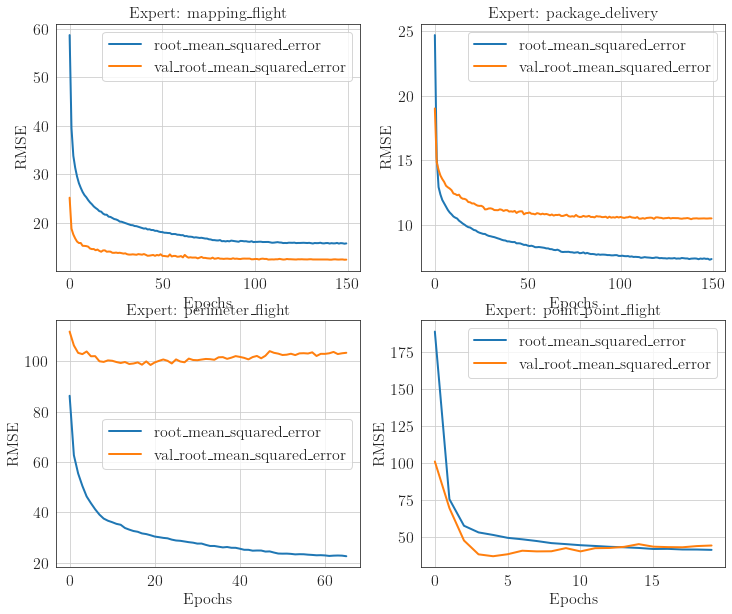

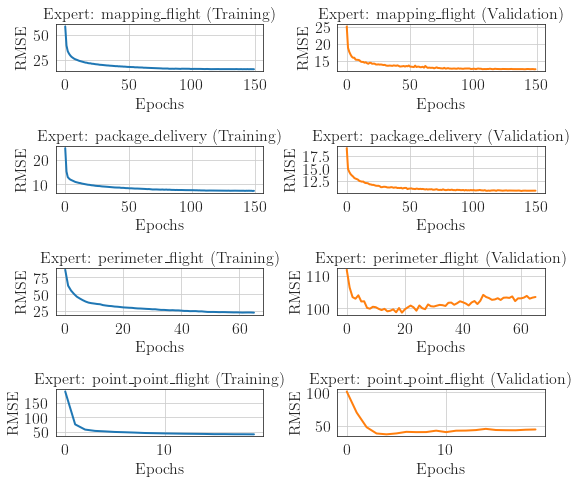

2991/2991 [==============================] - 6s 2ms/step
Shape of val_total_preds: (4, 95704, 12)
533/533 [==============================] - 1s 2ms/step
Shape of val_total_preds: (4, 17041, 12)
533/533 [==============================] - 1s 2ms/step
Shape of val_total_preds: (4, 26684, 12)
Shape of test_total_preds: (4, 17041, 12)
Deep MoE Average Time per Sample Prediction: 0.0003518339376145703


In [29]:
# Plot the RMSE results of each expert
Plots.RMSE_DMoE(moe_model)

# Plot the RMSE results of training and validation
Plots.RMS_pred(moe_model)
train_weighted_preds = moe_model.predict_Train(X_train_seq_std, X_train_meta, X_train_meta[:, 2:6])

# Prediction time for testing
start_pred_time = time()
test_weighted_preds = moe_model.predict_Train(X_test_seq_std, X_test_meta, X_test_meta[:, 2:6])
test_inference_time = time() - start_pred_time

# Results under validation and testing sets
(val_weighted_preds, test_weighted_preds) = moe_model.predict(X_val_seq_std, X_val_meta, 
                                                              X_val_meta[:, 2:6],
                                                              X_test_seq_std, X_test_meta,
                                                              X_test_meta[:, 2:6])

# also work out average time per prediction
time_per_pred = test_inference_time / X_test_seq_std.shape[0]
print(f"Deep MoE Average Time per Sample Prediction: {time_per_pred}")

# add our regression metric results to final dataframe
model_results = Plots.get_model_results(y_val, val_weighted_preds,
                                        y_test, test_weighted_preds, 
                                        "Deep MoE")

model_results['Training Time'] = moe_training_time
model_results['Avg Pred Time'] = time_per_pred
model_results['Window Size'] = WINDOW_SIZE

# append results to our final dataframe of results
final_results_df = final_results_df.append(model_results, ignore_index=True)

In [ ]:
# Numerical results of the DMoE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

trg_rmse = mean_squared_error(y_train, train_weighted_preds, squared=False)
val_rmse = mean_squared_error(y_val, val_weighted_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_weighted_preds, squared=False)

trg_mae = mean_absolute_error(y_train, train_weighted_preds)
val_mae = mean_absolute_error(y_val, val_weighted_preds)
test_mae = mean_absolute_error(y_test, test_weighted_preds)

trg_r2 = r2_score(y_train, train_weighted_preds)
val_r2 = r2_score(y_val, val_weighted_preds)
test_r2 = r2_score(y_test, test_weighted_preds)

print("Training Data:")
print(f"    - RMSE: {trg_rmse:.4f}")
print(f"    - MAE: {trg_mae:.4f}")
print(f"    - R^2: {trg_r2:.4f}")

print("\nValidation Data:")
print(f"    - RMSE: {val_rmse:.4f}")
print(f"    - MAE: {val_mae:.4f}")
print(f"    - R^2: {val_r2:.4f}")

print("\nTest Data:")
print(f"    - RMSE: {test_rmse:.4f}")
print(f"    - MAE: {test_mae:.4f}")
print(f"    - R^2: {test_r2:.4f}")

In [ ]:
# save our final modelling results to .csv for convenience
now = datetime.now()
current_date = now.strftime("%Y%m%d")
final_results_df.to_excel(f"{current_date}-final_reg_results.xlsx", index=False)

In [ ]:
# transform standardised predictions back to normal (use if outputs were scaled)
#trg_preds = y_scaler.inverse_transform(train_weighted_preds)
#val_preds = y_scaler.inverse_transform(val_weighted_preds)
#test_preds = y_scaler.inverse_transform(test_weighted_preds)

trg_preds = train_weighted_preds.copy()
val_preds = val_weighted_preds.copy()
test_preds = test_weighted_preds.copy()

In [ ]:
# Plot some random sample trajectories from the X_test sets
random_idx = np.random.choice(X_test.shape[0], 10, replace=False)
index = 0
for idx in random_idx:
    print(f"\nTest Example Results for idx: {idx}\n")
    index += 1
    # plot 2d results
    Plots.plot_bounds_results(idx, index, X_test, y_test, y_test_traj,
                              test_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx = 0, 
                              timestep=15, figsize=(10,4), legend = True)
    index += 1
    Plots.plot_bounds_results(idx, index, X_test, y_test, y_test_traj,
                              test_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=1, 
                              timestep=30, figsize=(10,4), legend= True, anomaly=False)
    
    #index += 1
    # plot 3d results
    #Plots.plot_bounds_results_3d(idx, index, X_test, y_test, y_test_traj, 
    #                             test_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=0, 
    #                             timestep=15, figsize=(10,10), legend = False)
    #index += 1
    #Plots.plot_bounds_results_3d(idx, index, X_test, y_test, y_test_traj,
    #                             trg_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=1, 
    #                             timestep=30, figsize=(10,10), legend= False, anomaly=False)

In [ ]:
# Plot some random results from the X_val set
random_idx = np.random.choice(X_val.shape[0], 10, replace=False)
for idx in random_idx:
    print(f"\nTest Example Results for idx: {idx}\n")
    index += 1
    # plot 2d results
    Plots.plot_bounds_results(idx, index, X_val, y_val, y_val_traj,
                              val_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx = 0, 
                              timestep=15, figsize=(10,4), legend = True)
    index += 1
    Plots.plot_bounds_results(idx, index, X_val, y_val, y_val_traj,
                              val_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=1, 
                              timestep=30, figsize=(10,4), legend= True, anomaly=False)
    
    #index += 1
    # plot 3d results
    #Plots.plot_bounds_results_3d(idx, index, X_val, y_val, y_val_traj, 
    #                             val_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=0, 
    #                             timestep=15, figsize=(10,10), legend = False)
    #index += 1
    #Plots.plot_bounds_results_3d(idx, index, X_val, y_val, y_val_traj,
    #                             val_preds, UAV_TYPE_IDX, UAV_INTENT_IDX, bound_idx=1, 
    #                             timestep=30, figsize=(10,10), legend= False, anomaly=False)